In [114]:
from groundedPL.codificacion import ToPropositionalLogic

parser = ToPropositionalLogic()
parser.debug = True

In [115]:
from groundedPL.logUtils import LogUtils
from typing import List, Tuple
NUM_FILAS = 8
NUM_COLUMNAS = 8
casillas = [(f"fila{x}", f"columna{y}")
            for x in range(NUM_FILAS) for y in range(NUM_COLUMNAS)]

#Deben haber 4 barcos en el mapa
def crear_regla_1():
    #Bn: Barco de n casillas (n=1,2,3,4)
    otoria_Bn = []
    for n in range(1, 5):
        for x in range(NUM_FILAS):
            for y in range(NUM_COLUMNAS):
                for i in range(n):
                    x2, y2 = x + i, y
                    if x2 < NUM_FILAS:
                        atomo = parser.to_nltk(f"EN({x},{y}, {x2},{y2})")
                        otoria_Bn.append(atomo)
                for j in range(n):
                    x2, y2 = x, y + j
                    if y2 < NUM_COLUMNAS:
                        atomo = parser.to_nltk(f"EN({x},{y}, {x2},{y2})")
                        otoria_Bn.append(atomo)
    # B1: Barco de 1 casilla 
    otoria_B1 = []
    for x in range(8):
        for y in range(8):
            x2, y2 = x, y
            formula = (f'EN({x},{y}, {x2},{y2})')
            atomo = parser.to_nltk(formula)
            otoria_B1.append(atomo)
    B1 = LogUtils.Otoria(otoria_B1)

    # B2: Barco de 2 casillas (horizontal o vertical)
    otoria_B2_h = []
    for x in range(7):
        ytoria = []
        for y in range(8):
            x2, y2 = x + 1, y
            formula = (f'EN({x},{y}, {x2},{y2})')
            atomo = parser.to_nltk(formula)
            ytoria.append(atomo)
        otoria_B2_h.append(LogUtils.Ytoria(ytoria))
    
    otoria_B2_v = []
    for y in range(7):
        ytoria = []
        for x in range(8):
            x2, y2 = x, y + 1 
            formula = (f'EN({x},{y}, {x2},{y2})')
            atomo = parser.to_nltk(formula)
            ytoria.append(atomo)
        otoria_B2_v.append(LogUtils.Ytoria(ytoria))
    
    B2 = LogUtils.Otoria(otoria_B2_h + otoria_B2_v)

    # B3: Barco de 3 casillas (horizontal o vertical)
    otoria_B3_h = []
    for x in range(7):
        ytoria = []
        for y in range(8):
            x2, y2 = x + 2, y
            formula = (f'EN({x},{y}, {x2},{y2})')
            atomo = parser.to_nltk(formula)     
            ytoria.append(atomo)
        otoria_B3_h.append(LogUtils.Ytoria(ytoria))
    
    otoria_B3_v = []
    for y in range(7):
        ytoria = []
        for x in range(8):
            x2, y2 = x, y + 2
            formula = (f'EN({x},{y}, {x2},{y2})')
            atomo = parser.to_nltk(formula)
            ytoria.append(atomo)
        otoria_B3_v.append(LogUtils.Ytoria(ytoria))
    B3 = LogUtils.Otoria(otoria_B3_h + otoria_B3_v)
    
    # B4: Barco de 4 casillas (horizontal o vertical)
    otoria_B4_h = []
    for x in range(7):
        ytoria = []
        for y in range(8):
            x2, y2 = x + 3, y
            formula = (f'EN({x},{y}, {x2},{y2})')
            atomo = parser.to_nltk(formula) 
            ytoria.append(atomo)
        otoria_B4_h.append(LogUtils.Ytoria(ytoria))
    
    otoria_B4_v = []
    for y in range(7):
        ytoria = []
        for x in range(8):
            x2, y2 = x, y + 3
            formula = (f'EN({x},{y}, {x2},{y2})')
            atomo = parser.to_nltk(formula) 
            ytoria.append(atomo)
        otoria_B4_v.append(LogUtils.Ytoria(ytoria))
    
    B4 = LogUtils.Otoria(otoria_B4_h + otoria_B4_v)

    regla_1 = LogUtils.Ytoria([B1, B2, B3, B4])
    return regla_1

""" 
def igual(x, x2):
    if x == x2:
        return True
    else:
        return False
def igual(y, y2):
    if y == y2:
        return True
    else:
        return False


# Al posicionar un barco, todas sus casillas deben estar alineadas en la misma fila o columna
def crear_regla_2():
    Ytoria_vf = []
    for x in range(NUM_FILAS):
        for y in range(NUM_COLUMNAS):
            for x2 in range(NUM_FILAS):
                for y2 in range(NUM_COLUMNAS):
                    iguales = igual(x, y) | igual(x2, y2)
                    formula = (f'EN({x},{y}, {x2},{y2}) > {iguales}')
                    atomo= parser.to_nltk(formula)
                    Ytoria_vf.append(atomo)
    regla_2 = LogUtils.Ytoria(Ytoria_vf)
    return regla_2
"""
def igual(x, x2):
    if x == x2:
        return True
    else:
        return False
def igual1(y, y2):
    if y == y2:
        return True
    else:
        return False
    
def crear_regla_2():
    Ytoria_vf = []
    for x in range(NUM_FILAS):
        for y in range(NUM_COLUMNAS):
            for x2 in range(NUM_FILAS):
                for y2 in range(NUM_COLUMNAS):
                    antecedente = parser.to_nltk(f"EN({x},{y}, {x2},{y2})")
                    consecuente =  parser.to_nltk(f"Igual({igual})"), parser.to_nltk(f"Igual({igual1})")  
                    implicacion = LogUtils.Ytoria(antecedente, consecuente)
                    Ytoria_vf.append(implicacion)
    regla_2 = LogUtils.Ytoria(Ytoria_vf)  # Conjunción universal (∀)
    return regla_2

# Para todo barco definifo, todas las casillas entre su inicio y su fin deben estar ocupadas por el barco
"""def crear_regla_3():
    Yrotia_vf = []
    for x in range(NUM_FILAS):
        for y in range(NUM_COLUMNAS):
            for x2 in range(NUM_FILAS):
                for y2 in range(NUM_COLUMNAS):
                    if igual(x, x2) or igual(y, y2):  
                        antecedente = parser.to_nltk(f"EN({x},{y},{x2},{y2})")
                        cuerpo = []
                        if x == x2: 
                            y_start, y_end = sorted([y, y2])
                            for y in range(y_start, y_end + 1):
                                cuerpo.append(parser.to_nltk(f"Oc({x},{y})"))
                        else: 
                            x_start, x_end = sorted([x, x2])
                            for x in range(x_start, x_end + 1):
                                cuerpo.append(parser.to_nltk(f"Oc({x},{y})"))
                        consecuente = LogUtils.Ytoria(cuerpo)
                        implicacion = parser.to_nltk(f"{antecedente} > {consecuente}")
                        Yrotia_vf.append(implicacion)
    return LogUtils.Ytoria(Yrotia_vf)"""


def entre_casillas(x: int, y: int, x2: int, y2: int) -> List[Tuple[int, int]]:
    casillas = []
    if igual(x,x2): 
        inicio, fin = sorted([y, y2])
        for y in range(inicio, fin + 1):
            casillas.append((x, y))
    elif igual1(y,y2) :
        inicio, fin = sorted([x, x2])
        for x in range(inicio, fin + 1):
            casillas.append((x, y))
    return casillas

def crear_regla_3():
    Ytoria_vf = []
    for x in range(NUM_FILAS):
        for y in range(NUM_COLUMNAS):
            for x2 in range(NUM_FILAS):
                for y2 in range(NUM_COLUMNAS):
                    casillas_entre = entre_casillas(x, y, x2, y2)
                    if not casillas_entre: 
                        continue
                    antecedente = parser.to_nltk(f"En({x},{y}, {x2},{y2})")
                    ocupadas = []
                    for (u, v) in casillas_entre:
                        ocupadas.append(parser.to_nltk(f"Oc({u},{v})"))
                    consecuente = LogUtils.Ytoria(ocupadas) 
                    implicacion = parser.to_nltk(f"{antecedente} > {consecuente}")
                    Ytoria_vf.append(implicacion)
    regla_3 = LogUtils.Ytoria(Ytoria_vf) 
    return regla_3

#No puede haber barcos sobrepuestos
def crear_regla_4():
    condiciones = []

    # Función auxiliar para obtener casillas de un barco
    def casillas_barco(x1, y1, x2, y2):
        if x1 == x2:  # Barco horizontal
            return {(x1, y) for y in range(min(y1, y2), max(y1, y2) + 1)}
        elif y1 == y2:  # Barco vertical
            return {(x, y1) for x in range(min(x1, x2), max(x1, x2) + 1)}
        return set()

    # Generar pares únicos de barcos
    for barco1 in crear_regla_2():
        x1, y1, x2, y2 = barco1
        casillas_b1 = casillas_barco(x1, y1, x2, y2)
        for barco2 in crear_regla_2():
            u1, v1, u2, v2 = barco2
            # Evitar comparar el mismo barco
            if barco1 == barco2:
                continue
            casillas_b2 = casillas_barco(u1, v1, u2, v2)
            # Si hay intersección, crear regla
            if casillas_b1 & casillas_b2:
                antecedente1 = parser.to_nltk(f"En({x1},{y1}, {x2},{y2})")
                antecedente2 = parser.to_nltk(f"En({u1},{v1}, {u2},{v2})")
                # Negar la coexistencia de ambos barcos
                formula = LogUtils.Negacion(LogUtils.Ytoria([antecedente1, antecedente2]))
                condiciones.append(formula)

    regla_4 = LogUtils.Ytoria(condiciones)
    return regla_4



# Definir barcos (hardcodeados como en tu ejemplo)
barcos = {
    'B1': [("fila0", "columna0")],  # Barco tamaño 1
    'B2': [("fila1", "columna0"), ("fila1", "columna1")],  # Barco tamaño 2 vertical
    'B3': [("fila2", "columna0"), ("fila2", "columna1"), ("fila2", "columna2")],  # Barco tamaño 3 horizontal
    'B4': [("fila3", "columna0"), ("fila3", "columna1"), ("fila3", "columna2"), ("fila3", "columna3")]  # Barco tamaño 4 vertical
}
"""barcos = {
    'B1': [("fila0", "columna0"), ("fila0", "columna0")],
    'B2': [("fila1", "columna0"), ("fila1", "columna1")],
    'B3': [("fila2", "columna0"), ("fila2", "columna2")],
    'B4': [("fila3", "columna0"), ("fila3", "columna3")]
}"""


# Función para imprimir barcos y casillas vacías
def imprimir_estado(barcos, casillas):
    for nombre, posiciones in barcos.items():
        print(f"\n{nombre}:")
        print(f"{nombre} definido entre {', '.join([f'({x},{y})' for x, y in posiciones])}")
    
    casillas_ocupadas = [pos for posiciones in barcos.values() for pos in posiciones]
    casillas_vacias = [f"¬BARCO({x}, {y})" for x, y in casillas if (x, y) not in casillas_ocupadas]
    
    print("\nCasillas vacías:")
    print(casillas_vacias)


imprimir_estado(barcos, casillas)



B1:
B1 definido entre (fila0,columna0)

B2:
B2 definido entre (fila1,columna0), (fila1,columna1)

B3:
B3 definido entre (fila2,columna0), (fila2,columna1), (fila2,columna2)

B4:
B4 definido entre (fila3,columna0), (fila3,columna1), (fila3,columna2), (fila3,columna3)

Casillas vacías:
['¬BARCO(fila0, columna1)', '¬BARCO(fila0, columna2)', '¬BARCO(fila0, columna3)', '¬BARCO(fila0, columna4)', '¬BARCO(fila0, columna5)', '¬BARCO(fila0, columna6)', '¬BARCO(fila0, columna7)', '¬BARCO(fila1, columna2)', '¬BARCO(fila1, columna3)', '¬BARCO(fila1, columna4)', '¬BARCO(fila1, columna5)', '¬BARCO(fila1, columna6)', '¬BARCO(fila1, columna7)', '¬BARCO(fila2, columna3)', '¬BARCO(fila2, columna4)', '¬BARCO(fila2, columna5)', '¬BARCO(fila2, columna6)', '¬BARCO(fila2, columna7)', '¬BARCO(fila3, columna4)', '¬BARCO(fila3, columna5)', '¬BARCO(fila3, columna6)', '¬BARCO(fila3, columna7)', '¬BARCO(fila4, columna0)', '¬BARCO(fila4, columna1)', '¬BARCO(fila4, columna2)', '¬BARCO(fila4, columna3)', '¬BARCO(fil

---

# Interpretaciones y descriptores <a class="anchor" id="interp"></a>

([Volver al inicio](#inicio))



In [168]:
"""parser.debug = False
# Crear un diccionario para representar las posiciones ocupadas por los barcos
Entre = [pos for posiciones in barcos.values() for pos in posiciones]
I = {
    parser.parse(f"EN({NUM_FILAS}, {NUM_COLUMNAS})"): (NUM_FILAS, NUM_COLUMNAS) in Entre
    for NUM_FILAS, NUM_COLUMNAS in casillas
}

# Mostrar el resultado
print(I)"""

'parser.debug = False\n# Crear un diccionario para representar las posiciones ocupadas por los barcos\nEntre = [pos for posiciones in barcos.values() for pos in posiciones]\nI = {\n    parser.parse(f"EN({NUM_FILAS}, {NUM_COLUMNAS})"): (NUM_FILAS, NUM_COLUMNAS) in Entre\n    for NUM_FILAS, NUM_COLUMNAS in casillas\n}\n\n# Mostrar el resultado\nprint(I)'

In [172]:
# Descriptor 1: En
parser.debug = False

Entre = [pos for posiciones in barcos.values() for pos in posiciones]
I = {
    parser.parse(f"En({x},{y})"): (f"fila{x}", f"columna{y}") in Entre
    for x in range(NUM_FILAS) for y in range(NUM_COLUMNAS)
}
print("En:", I)

En: {'ず': True, '㌳': False, '㘌': False, '㣥': False, '㮾': False, '㺗': False, '䅰': False, '䑉': False, 'ふ': True, '㍎': True, '㘧': False, '㤀': False, '㯙': False, '㺲': False, '䆋': False, '䑤': False, 'ゐ': True, '㍩': True, '㙂': True, '㤛': False, '㯴': False, '㻍': False, '䆦': False, '䑿': False, 'カ': True, '㎄': True, '㙝': True, '㤶': True, '㰏': False, '㻨': False, '䇁': False, '䒚': False, 'テ': False, '㎟': False, '㙸': False, '㥑': False, '㰪': False, '㼃': False, '䇜': False, '䒵': False, 'メ': False, '㎺': False, '㚓': False, '㥬': False, '㱅': False, '㼞': False, '䇷': False, '䓐': False, 'ー': False, '㏕': False, '㚮': False, '㦇': False, '㱠': False, '㼹': False, '䈒': False, '䓫': False, 'ㄗ': False, '㏰': False, '㛉': False, '㦢': False, '㱻': False, '㽔': False, '䈭': False, '䔆': False}


In [143]:
"""parser.debug = False

ocupadas = [pos for posiciones in barcos.values() for pos in posiciones]

Oc = {
    parser.parse(f"Oc({NUM_FILAS}, {NUM_COLUMNAS})"): (NUM_FILAS, NUM_COLUMNAS) in ocupadas
    for NUM_FILAS, NUM_COLUMNAS in casillas
}

print(Oc)"""

'parser.debug = False\n\nocupadas = [pos for posiciones in barcos.values() for pos in posiciones]\n\nOc = {\n    parser.parse(f"Oc({NUM_FILAS}, {NUM_COLUMNAS})"): (NUM_FILAS, NUM_COLUMNAS) in ocupadas\n    for NUM_FILAS, NUM_COLUMNAS in casillas\n}\n\nprint(Oc)'

In [173]:
# Descriptor 2: Oc
parser.debug = False
ocupadas = [pos for posiciones in barcos.values() for pos in posiciones]
Oc = {
    parser.parse(f"Oc({x},{y})"): (f"fila{x}", f"columna{y}") in ocupadas
    for x in range(NUM_FILAS) for y in range(NUM_COLUMNAS)
}
print("Oc:", Oc)

Oc: {'す': True, '㌲': False, '㘋': False, '㣤': False, '㮽': False, '㺖': False, '䅯': False, '䑈': False, 'ぴ': True, '㍍': True, '㘦': False, '㣿': False, '㯘': False, '㺱': False, '䆊': False, '䑣': False, 'わ': True, '㍨': True, '㙁': True, '㤚': False, '㯳': False, '㻌': False, '䆥': False, '䑾': False, 'オ': True, '㎃': True, '㙜': True, '㤵': True, '㰎': False, '㻧': False, '䇀': False, '䒙': False, 'ヅ': False, '㎞': False, '㙷': False, '㥐': False, '㰩': False, '㼂': False, '䇛': False, '䒴': False, 'ム': False, '㎹': False, '㚒': False, '㥫': False, '㱄': False, '㼝': False, '䇶': False, '䓏': False, '・': False, '㏔': False, '㚭': False, '㦆': False, '㱟': False, '㼸': False, '䈑': False, '䓪': False, 'ㄖ': False, '㏯': False, '㛈': False, '㦡': False, '㱺': False, '㽓': False, '䈬': False, '䔅': False}


In [198]:
from itertools import combinations
# Descriptor 3: Igual (para filas y columnas)
parser.debug = False
Igual_filas = {}
Igual_columnas = {}

for barco in barcos.values():    
    for (x, y), (x2, y2) in combinations(barco, 2):
        # Comparar filas
        formula_fila = parser.parse(f"Igual_fila({x},{x2})")
        Igual_filas[formula_fila] = igual1(x, x2)
        # Comparar columnas
        formula_columna = parser.parse(f"Igual_columna({y},{y2})")
        Igual_columnas[formula_columna] = igual(y, y2)

print("\nIgual (filas):", Igual_filas)
print("\nIgual (columnas):", Igual_columnas)


Igual (filas): {'ᾱ': True, '⌗': True, '♽': True}

Igual (columnas): {'ߋ': False, 'ଔ': False, '\u0b31': False, '\u0e5d': False, '\u0e7a': False, 'ທ': False}


---

# Visualización de interpretaciones <a class="anchor" id="visual"></a>

([Volver al inicio](#inicio))



In [174]:
atomo = list(I.keys())[0]
print(f'{atomo=}')
print(f'Formula: {parser.leer(atomo)}')
print(f'{parser.obtener_argumentos(atomo)}')
parser.obtener_predicado(atomo)

atomo='ず'
Formula: En(0, 0)
['0', '0']


'En'

In [175]:
atomo = list(Oc.keys())[0]
print(f'{atomo=}')
print(f'Formula: {parser.leer(atomo)}')
print(f'{parser.obtener_argumentos(atomo)}')
parser.obtener_predicado(atomo)

atomo='す'
Formula: Oc(0, 0)
['0', '0']


'Oc'

In [191]:
atomo = list(Igual_columnas.keys())[0]
print(f'{atomo=}')
print(f'Formula: {parser.leer(atomo)}')
print(f'{parser.obtener_argumentos(atomo)}')
parser.obtener_predicado(atomo)

atomo='ߋ'
Formula: Igual_columna(columna0, columna1)
['columna0', 'columna1']


'Igual_columna'

In [188]:
atomo = list(Igual_filas.keys())[0]
print(f'{atomo=}')
print(f'Formula: {parser.leer(atomo)}')
print(f'{parser.obtener_argumentos(atomo)}')
parser.obtener_predicado(atomo)

atomo='ᾱ'
Formula: Igual_fila(fila1, fila1)
['fila1', 'fila1']


'Igual_fila'

In [176]:
from typing import Tuple

def obtener_fila_columna(atomo:str) -> Tuple[int, int]:
    fila, columna = parser.obtener_argumentos(atomo)
    num_fila = NUM_FILAS.index(fila)
    num_columna = NUM_COLUMNAS.index(columna)
    return num_fila, num_columna
    

### Ejercicio 3:

Cree una función de visualización para representar una situación apropiada de su proyecto. Utilice la interpretación desarrollada en el ejercicio 2 como argumento.

In [177]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

def visualizar_batalla_naval(barcos):
    fig, tablero = plt.subplots(figsize=(6, 6))
    tablero.set_xlim(0, 8) #Define el limite del tablero 
    tablero.set_ylim(0, 8)
    tablero.set_xticks(range(9))
    tablero.set_yticks(range(9))
    tablero.set_xticklabels(range(0, 9))
    tablero.set_yticklabels(range(0, 9))
    tablero.grid(True, color='black', linewidth=1)
    tablero.set_title("Tablero de Batalla Naval", fontsize=16)
    tablero.set_xlabel("Columnas", fontsize=12)
    tablero.set_ylabel("Filas", fontsize=12)

    # Colores
    agua_color = 'lightblue'
    barco_color = 'darkgray'
    borde_color = 'black'

    # Dibujar todas las casillas como agua primero
    for x in range(8):
        for y in range(8):
            rect = patches.Rectangle(
                (y, x), 1, 1, 
                facecolor=agua_color, 
                edgecolor=borde_color,
                linewidth=1
            )
            tablero.add_patch(rect)

    # Dibujar los barcos según su tamaño
    for nombre, posiciones in barcos.items():
        # Determinar si el barco es horizontal o vertical
        if len(posiciones) > 1:
            primera = posiciones[0]
            ultima = posiciones[-1]
            x1, y1 = int(primera[0].replace("fila", "")), int(primera[1].replace("columna", ""))
            x2, y2 = int(ultima[0].replace("fila", "")), int(ultima[1].replace("columna", ""))
            
            if x1 == x2:  # Barco horizontal
                width = len(posiciones)
                height = 1
                y = y1
            else:  # Barco vertical
                width = 1
                height = len(posiciones)
                y = y1
                
            rect = patches.Rectangle(
                (y, x1), width, height,
                facecolor=barco_color,
                edgecolor=borde_color,
                linewidth=2
            )
            tablero.add_patch(rect)
            
            # Texto con el tamaño del barco
            tablero.text(y + width/2, x1 + height/2, f"{len(posiciones)}",
                    ha='center', va='center', 
                    fontsize=12, color='red')
        else:  # Barco de 1 casilla
            x = int(posiciones[0][0].replace("fila", ""))
            y = int(posiciones[0][1].replace("columna", ""))
            rect = patches.Rectangle(
                (y, x), 1, 1,
                facecolor=barco_color,
                edgecolor=borde_color,
                linewidth=2
            )
            tablero.add_patch(rect)
            tablero.text(y + 0.5, x + 0.5, "1",
                    ha='center', va='center', 
                    fontsize=12, color='red')

    plt.gca().invert_yaxis()  # Para que fila 0 esté arriba
    plt.show()

# Ejemplo de uso con barcos de diferentes tamaños
I = {
    'B1': [("fila0", "columna0")],  # Barco tamaño 1
    'B2': [("fila1", "columna0"), ("fila1", "columna1")],  # Barco tamaño 2 vertical
    'B3': [("fila2", "columna0"), ("fila2", "columna1"), ("fila2", "columna2")],  # Barco tamaño 3 horizontal
    'B4': [("fila3", "columna0"), ("fila3", "columna1"), ("fila3", "columna2"), ("fila3", "columna3")]  # Barco tamaño 4 vertical
}


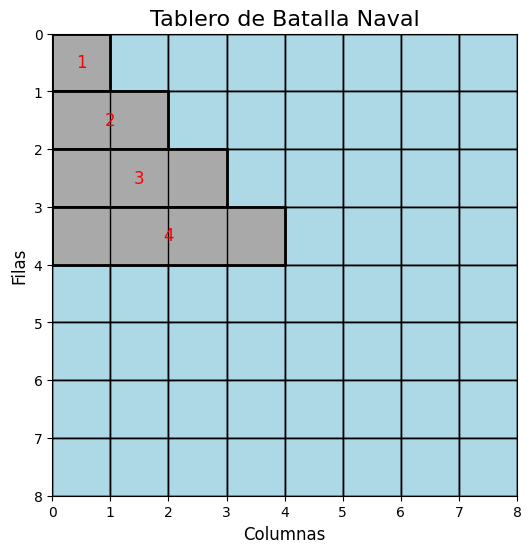

In [178]:
visualizar_batalla_naval(I)

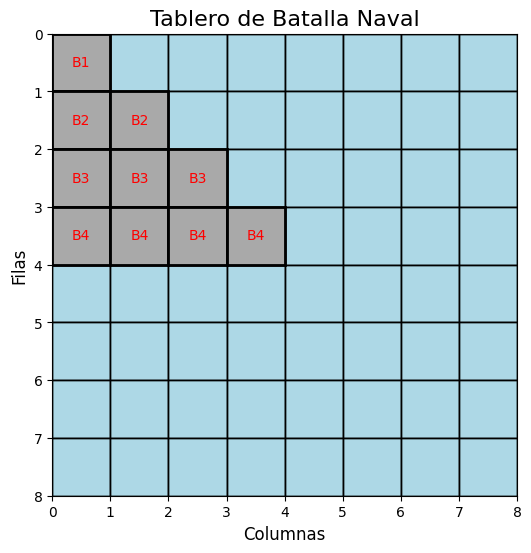

In [179]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def obtener_casillas_desde_extremos(extremo1, extremo2):
    x1, y1 = int(extremo1[0].replace("fila", "")), int(extremo1[1].replace("columna", ""))
    x2, y2 = int(extremo2[0].replace("fila", "")), int(extremo2[1].replace("columna", ""))

    casillas = []
    if x1 == x2:
        for y in range(min(y1, y2), max(y1, y2) + 1):
            casillas.append((f"fila{x1}", f"columna{y}"))
    elif y1 == y2:
        for x in range(min(x1, x2), max(x1, x2) + 1):
            casillas.append((f"fila{x}", f"columna{y1}"))
    else:
        casillas.append((extremo1, extremo2))
    return casillas

def visualizar_batalla_naval(barcos):
    fig, tablero = plt.subplots(figsize=(6, 6))
    tablero.set_xlim(0, 8)
    tablero.set_ylim(0, 8)
    tablero.set_xticks(range(9))
    tablero.set_yticks(range(9))
    tablero.set_xticklabels(range(0, 9))
    tablero.set_yticklabels(range(0, 9))
    tablero.grid(True, color='black', linewidth=1)
    tablero.set_title("Tablero de Batalla Naval", fontsize=16)
    tablero.set_xlabel("Columnas", fontsize=12)
    tablero.set_ylabel("Filas", fontsize=12)

    agua_color = 'lightblue'
    barco_color = 'darkgray'
    borde_color = 'black'

    for x in range(8):
        for y in range(8):
            rect = patches.Rectangle(
                (y, x), 1, 1, 
                facecolor=agua_color, 
                edgecolor=borde_color,
                linewidth=1
            )
            tablero.add_patch(rect)

    for nombre, posiciones in barcos.items():
        for pos in posiciones:
            x = int(pos[0].replace("fila", ""))
            y = int(pos[1].replace("columna", ""))
            rect = patches.Rectangle(
                (y, x), 1, 1,
                facecolor=barco_color,
                edgecolor=borde_color,
                linewidth=2
            )
            tablero.add_patch(rect)
            tablero.text(y + 0.5, x + 0.5, nombre,
                        ha='center', va='center', 
                        fontsize=10, color='red')

    plt.gca().invert_yaxis()
    plt.show()


I = {
    'B1': [('fila0', 'columna0'), ('fila0', 'columna0')],
    'B2': [('fila1', 'columna0'), ('fila1', 'columna1')],
    'B3': [('fila2', 'columna0'), ('fila2', 'columna2')],
    'B4': [('fila3', 'columna0'), ('fila3', 'columna3')]
}

barcos_expandido = {}

for nombre, extremos in I.items():
    if len(extremos) == 2:
        casillas = obtener_casillas_desde_extremos(extremos[0], extremos[1])
        barcos_expandido[nombre] = casillas
    else:
        barcos_expandido[nombre] = extremos

visualizar_batalla_naval(barcos_expandido)


---